# Normal Poseidon Inputs

Just for simplicity, we define a hot jupiter composed of only H and He in order to display the effects of Mie Scattering

In [1]:
from POSEIDON.core import wl_grid_constant_R
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J
import scipy.constants as sc

#***** Define stellar properties *****#

R_s = 1.49*R_Sun     # Stellar radius (m)
T_s = 6550            # Stellar effective temperature (K)
Met_s = -0.25          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.2        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'Mie_Testing'  # Planet name used for plots, output files etc.

R_p = 1.87*R_J                           # Planetary radius (m)
R_p = 1.722*R_J
M_p = 0.78*M_J
# Formula : a = GM/R^2
g_p = (sc.G*M_p)/(R_p**2)         # Gravitational field of planet (m/s^2)
T_eq = 1447

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

CB_color_cycle = ['#0072B2', '#009E73', '#D55E00', '#CC79A7',
                 '#F0E442', '#56B4E9','#56B4E9']



wl_min = 0.2    # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 1000       # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

/Users/elijahmullens/Desktop/POSEIDON-V1-1/POSEIDON/absorption.py:1479: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


In [2]:
from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

#***** Specify data location and instruments  *****#
data_dir = '.' 

datasets = ['Wasp-17b-bin025-ExoTiC',
            'W17_pre_Jwst_data.txt']
instruments = ['JWST_MIRI_LRS',
               'None']

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl,
                 offset_datasets = ['Wasp-17b-bin025-ExoTiC'])

POSEIDON does not currently have an instrument transmission function for None, so a box function will be used.


# SLAB

In [2]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Slab_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O', 'CH4', 'CO2', 'Na', 'K', 'CO']

aerosol_species = ['SiO2']

# Create the model object
model = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'slab',
                     aerosol_species = aerosol_species)


# Check the free parameters defining this model
print("Free parameters model 1: " + str(model['param_names']))
print()
print('Here the P_cloud is the cloud top')

Reading in database for aerosol cross sections...
Free parameters model 1: ['R_p_ref' 'T' 'log_H2O' 'log_CH4' 'log_CO2' 'log_Na' 'log_K' 'log_CO'
 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_SiO2']

Here the P_cloud is the cloud top


In [4]:
from POSEIDON.utility import read_chem_file
from POSEIDON.core import make_atmosphere
import numpy as np
import matplotlib.pyplot as plt

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p # Radius at reference pressure

# X Params
PT_params = np.array([1200])

log_X_params = np.array([[-4.48,-7.9,-5.28,-7.66,-9.11,-8.06]])

log_P_cloud_SiO2             =   -5
Delta_log_P_SiO2             =   2
log_r_m_SiO2                 =   -1.7
log_X_SiO2                   =   -13
cloud_params = np.array([log_P_cloud_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2])

# Generate the atmospheres
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

In [5]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

wl_min = 0.2    # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 100       # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CH4 done
CO2 done
Na done
K done
CO done
Opacity pre-interpolation complete.


In [6]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection


# Generate our first transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')

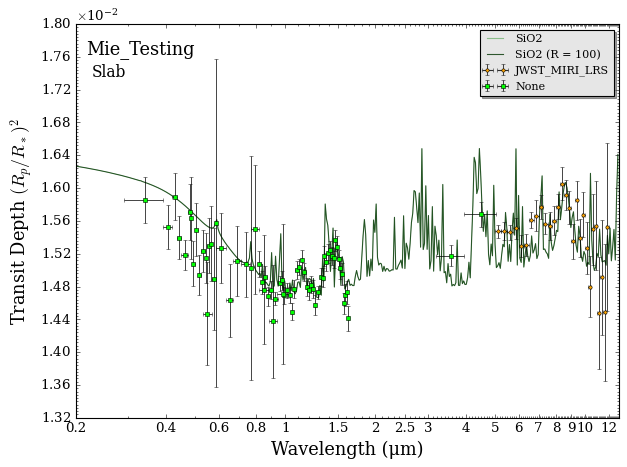

In [7]:
# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = [])

# Produce figure and save to file

fig = plot_spectra(spectra, planet, data, R_to_bin = 100, 
                   spectra_labels = ['SiO2'], 
                   plt_label = 'Slab',
                   show_data = True) 

# Retrieval Tests

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J
import scipy.constants as sc

#
#***** Define stellar properties *****#

# Stassun et al 2017
R_s = 1.49*R_Sun     # Stellar radius (m)
T_s = 6550            # Stellar effective temperature (K)
Met_s = -0.25          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.2        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-17b'  # Planet name used for plots, output files etc.

# Taken from Stassun et al 2017
R_p = 1.87*R_J                           # Planetary radius (m)
M_p = 0.78*M_J
# Formula : a = GM/R^2
g_p = (sc.G*M_p)/(R_p**2)         # Gravitational field of planet (m/s^2)

# Barstow et al 2017
T_eq = 1738       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

wl_min = 0.2     # Minimum wavelength (um)
wl_max = 13      # Maximum wavelength (um)
R = 1000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Specify data location and instruments  *****#

from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

#***** Specify data location and instruments  *****#
data_dir = '.' 

datasets = ['Wasp-17b-bin025-ExoTiC',
            'W17_pre_Jwst_data.txt']
instruments = ['JWST_MIRI_LRS',
               'None']

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl,
                 offset_datasets = ['Wasp-17b-bin025-ExoTiC'])

#***** Define models *****#
from POSEIDON.core import define_model

model_name = 'Slab_SiO2_Test'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O', 'CH4', 'CO2', 'Na', 'K', 'CO']
aerosol_species = ['SiO2']

# Create the model object
model = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'slab',
                     aerosol_species = aerosol_species,
                     offsets_applied= 'single_dataset')

from POSEIDON.core import set_priors

#***** Set priors for retrieval *****#

log_r_m_string = 'log_r_m_' + aerosol_species[0]
log_X_string = 'log_X_' + aerosol_species[0]
log_P_cloud_string = 'log_P_cloud_' + aerosol_species[0]
Delta_log_P_string = 'Delta_log_P_' + aerosol_species[0]

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'

prior_types['log_X'] = 'uniform'

prior_types['delta_rel'] = 'uniform'

prior_types[log_r_m_string] = 'uniform'
prior_types[log_X_string] = 'uniform'
prior_types[log_P_cloud_string] = 'uniform'
prior_types[Delta_log_P_string] = 'uniform'

prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [400, 2300]
prior_ranges['R_p_ref'] = [1.5895*R_J, 2.1505*R_J]
prior_ranges['log_X'] = [-12, -1]
prior_ranges['delta_rel'] = [-1000, 1000]

prior_ranges[log_r_m_string] = [-3,1]
prior_ranges[log_X_string] = [-30,-1]
prior_ranges[log_P_cloud_string] = [-7,2]
prior_ranges[Delta_log_P_string] = [0,9]

priors = set_priors(planet, star, model, data, prior_types, prior_ranges)

from POSEIDON.core import read_opacities
import numpy as np

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 400     # Same as prior range for T
T_fine_max = 2300    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step),
                       log_P_fine_step)

# Pre-interpolate the opacities
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

from POSEIDON.retrieval import run_retrieval

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)

run_retrieval(planet, star, model, opac, data, priors, wl, P, P_ref, R = R,
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest',
              N_live = 50, verbose = True)

/Users/elijahmullens/Desktop/POSEIDON-V1-1/POSEIDON/absorption.py:1479: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


POSEIDON does not currently have an instrument transmission function for None, so a box function will be used.
Reading in database for aerosol cross sections...
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CH4 done
CO2 done
Na done
K done
CO done
Opacity pre-interpolation complete.
POSEIDON now running 'Slab_SiO2_Test'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =   50
 dimensionality =   13
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.813008
Replacements:                                100
Total Samples:                               123
Nested Sampling ln(Z):              -6446.289928
Acceptance Rate:                        0.721154
Replacements:           

Generating corner plot ...


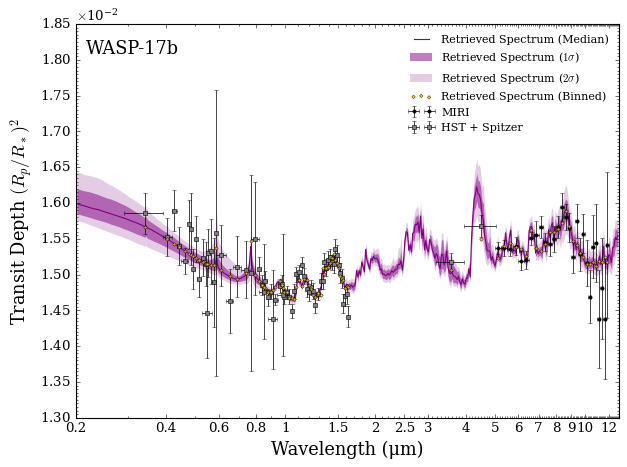

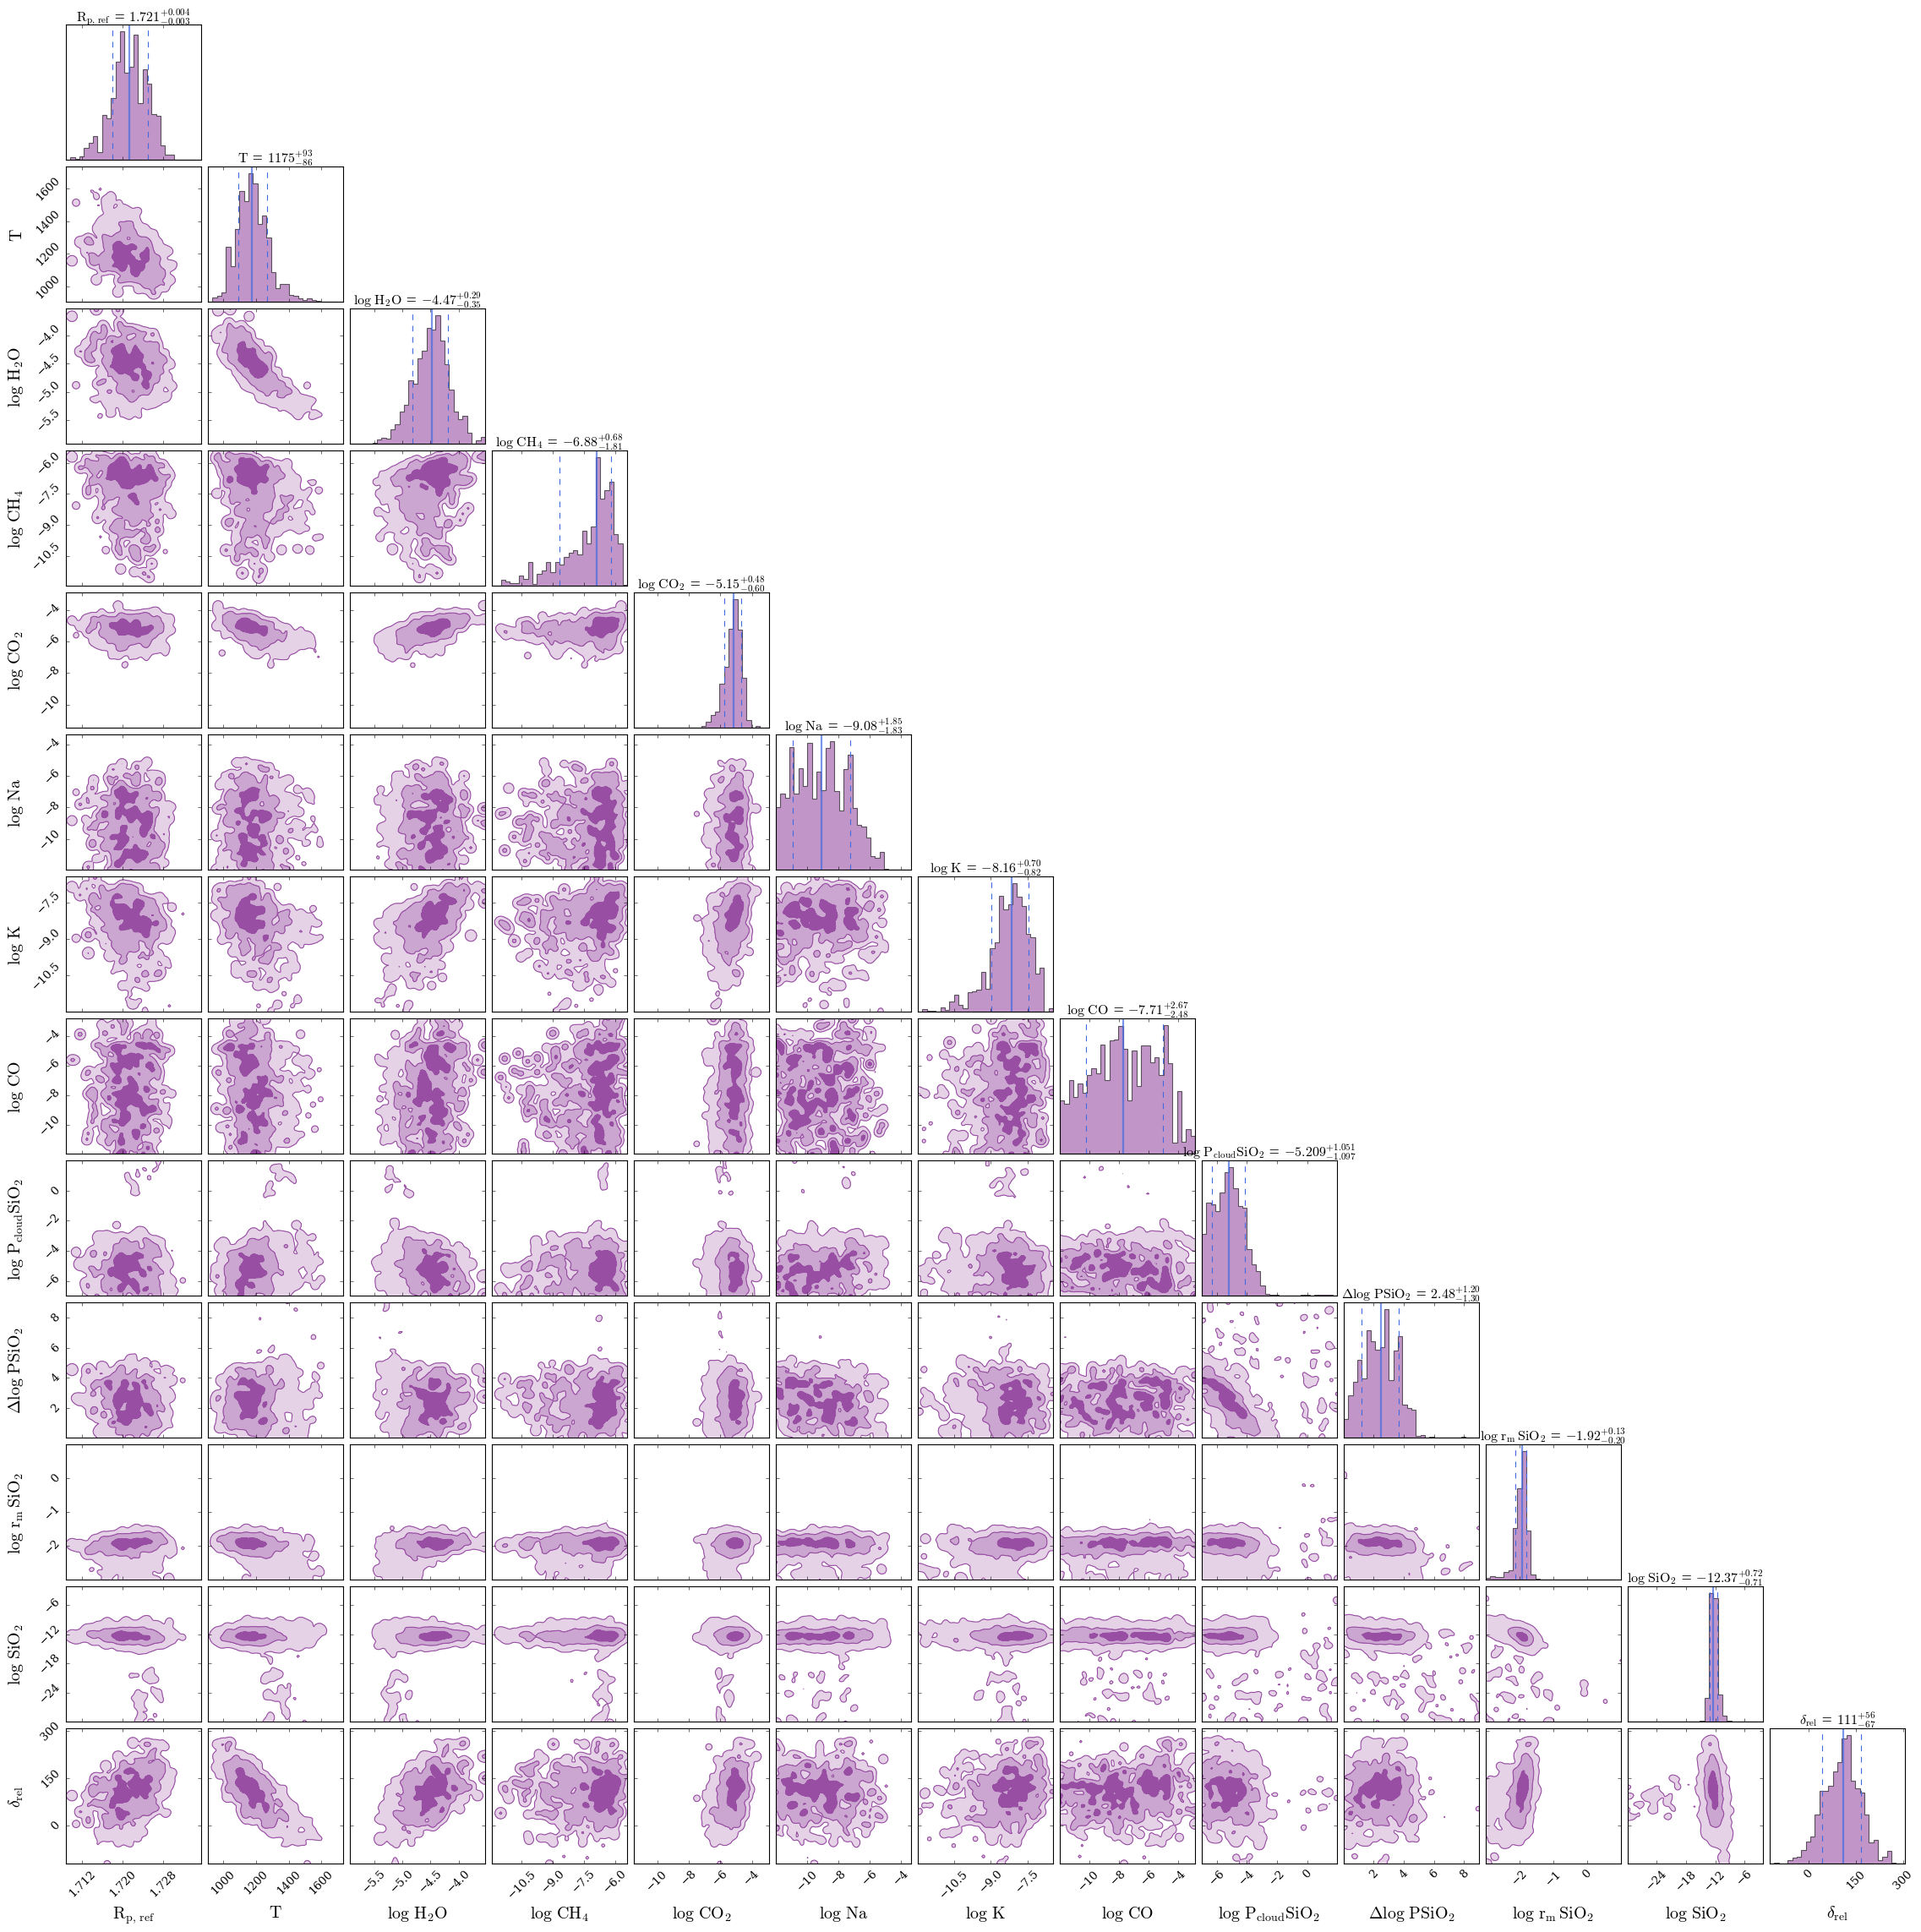

In [4]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved
from POSEIDON.corner import generate_cornerplot

#***** Plot retrieved transmission spectrum *****#

ydata = data['ydata']                 # Transit depths from the data files
offset_start = data['offset_start']   # Index where WFC3 data starts
offset_end = data['offset_end']       # Index where WFC3 data ends

offset = 105.64
offset = offset * 1e-6
# Apply median retrieved offset to the WFC3 data
ydata[offset_start:offset_end] -= offset

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data, R_to_bin = 100,
                                  data_labels = ['MIRI', 'HST + Spitzer'],
                                  data_colour_list = ['black', 'gray',])

#***** Make corner plot *****#

fig_corner = generate_cornerplot(planet, model)

ydata[offset_start:offset_end] += offset